# Загрузка библиотек и предобработка колонок с числовыми данными

In [64]:
import pandas as pd
from sklearn.model_selection import train_test_split # Загружаем специальный инструмент для разбивки данных
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели
import numpy as np
import re
import requests as req
from bs4 import BeautifulSoup
import urllib3
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt

rest = pd.read_csv("C:/Users/Admin/FierceDra-X.github.io/module_3/main_task_new.csv")
# кроме исходных данных, загрузим дополнительные внешние данные: количество посещений туристами городов
#по 12 городам данные взяты из рейтинга ТОП-50 самых посещаемых городв
# по остальным взята одна треть от минимально посещаемого города из 12 городов (это Афины деленные на 3)
cities_tourists = pd.read_csv("C:/Users/Admin/FierceDra-X.github.io/module_3/Cities_tourists.csv", sep=';')
cities_tourists_ind = cities_tourists.set_index('City')

#создадим датафрей для загрузки в модель и для начала загрузим в него численные данные
rest_model = rest.select_dtypes(include=[np.number])

#посмотрим в каких колонках есть пустые значения
rest_model.Ranking.isna().value_counts(normalize=True)
rest_model['Number of Reviews'].isna().value_counts(normalize=True)

#в колонке Number of Reviews 6.3% пропусков.
#заполним пропущенные значения средним значением
rest_model = rest_model.fillna(rest_model['Number of Reviews'].mean())

rest_model
#запуск модели дал MAE=0.4288

,Ranking,Rating,Number of Reviews
0,5570.0,3.5,194.0
1,1537.0,4.0,10.0
2,353.0,4.5,688.0
3,3458.0,5.0,3.0
4,621.0,4.0,84.0
...,...,...,...
39995,500.0,4.5,79.0
39996,6341.0,3.5,542.0
39997,1652.0,4.5,4.0
39998,641.0,4.0,70.0


# Предобработка колонки City

,Ranking,Rating,Number of Reviews,cities_category
0,5570.0,3.5,194.0,15834200
1,1537.0,4.0,10.0,1598133
2,353.0,4.5,688.0,19827800
3,3458.0,5.0,3.0,5627400
4,621.0,4.0,84.0,1598133
...,...,...,...,...
39995,500.0,4.5,79.0,6347900
39996,6341.0,3.5,542.0,15834200
39997,1652.0,4.5,4.0,1598133
39998,641.0,4.0,70.0,1598133


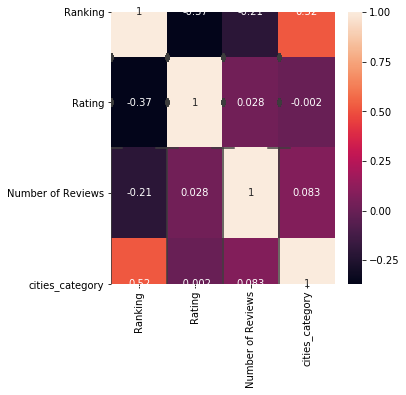

In [65]:
#посмотрим на столбец City, есть ли пропуски, сколько и какие уникальные города
rest.City.isna().value_counts()
rest.City.unique()

#пропусков нет, предположим, что самые посещаемые туристами города имеют более высокие рейтинги (гипотеза для проверки)
#в силу стремления лучших поваров в эти города
# разобьем все города на 4 категории по посещаемости туристами
# в списке оказалось 12 городов, попавших в рейтинг 50-ти самых посещаемых и 5 в ТОП-25
#заменим города на ординальную переменную со значениями 1,3, 7 и 10 (1 - это города, не вошедшие в 12 городв из ТОП-50)
tourist_centers_low = ['Athens','Dublin','Madrid','Berlin']
tourist_centers_middle = ['Vienna','Milan','Barcelona']
tourist_centers_top = ['Amsterdam','Prague','Rome','Paris','London']

#функция для создания нового столбца с ординальной переменной
def city_category(city):
    if city in tourist_centers_top:
        return 10
    elif city in tourist_centers_middle:
        return 7
    elif city in tourist_centers_low:
        return 3
    else:
        return 1

rest_model['cities_category'] = rest.City.apply(city_category)

#визуализируем данные, посмотрим есть ли значимое влияние на целевую переменную новой колонки
heatmap = plt.figure(figsize=(5, 5))
sns.boxplot(x="cities_category", y="Rating", data=rest_model)
sns.heatmap(rest_model.corr(method='pearson'), annot=True) #да, корреляция новых данных с целевой переменной получилась макисмальной

rest_model
#запуск модели дал MAE=0.317 - серьезное улучшение

#теперь попробуем загрузить в колонку более точные данные из датасета cities_tourists, посмотрим как повлияет на точность модели
def city_category_outer(city):
    return cities_tourists_ind['Tourists'].loc[city]

rest_model['cities_category'] = rest.City.apply(city_category_outer)
rest_model
#запуск модели дал MAE=0.275 - еще лучше, видимо попали в очень значимый фактор

# Работа с колонкой интернет ссылок на рестораны

In [66]:
#на ум пришла гипотеза, что Ranking в исходных данных не несет полной информации о рейтинге ресторана
#не понятно, стоит ли рейтинг в топе или в низу полного списка
#скачаем данные о полном количестве ресторанов, участвующих в рэнкинге для большой части городов
#потом расчитаем долю Ranking в общем количестве ресторанов в рэнекинге, это даст понимание в топе ресторан или внизу рэнкинга

urllib3.disable_warnings()
header = {'user-agent': 'Chrome/58.0.3029.83 Mobile Safari/537.36'} #будем обращаться к мобильной версии сайта, почему то полная версия зависает

#функция добавления основной части сайта к колонке URL_TA
def site_add (site):
    return 'https://www.tripadvisor.com'+site

rest['url'] = rest['URL_TA'].apply(lambda x: site_add(x)) #создаем новую колонку с полными сайтами ресторанов

rest_filtered = rest.iloc[:150] #ограничимся 150 сайтами, полный парсинг занимает много времени, не все города могут попасть, но большая часть из них достаточна

#функция поиска и скачивания общего количества ресторанов в рэнкинге
def ranking_add(site):
    response = req.get(site, headers=header, timeout=20, verify=False)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text,'html.parser')
        Full_rest_numbers = soup.find('span', class_="dyeJW dUpPX")
        if not Full_rest_numbers == None:
            Full_rest_number = re.sub("[^0-9 ]","",Full_rest_numbers.text).strip()
            return Full_rest_number
        else:
            return 0

#rest_filtered['Full_rest_numbers'] = rest_filtered['url'].apply(ranking_add) #доавляем новую колонку с данными с сайтов
#rest_filtered.to_csv("C:/Users/Admin/FierceDra-X.github.io/module_3/rest_filtered.csv") #сохраним данные в отдельном файле

rest_filtered = pd.read_csv("C:/Users/Admin/FierceDra-X.github.io/module_3/rest_filtered.csv")
#чистим данные в колонке
rest_filtered['Ranking_total'] = rest_filtered['Full_rest_numbers'].apply(lambda x: re.sub("[^0-9]","",str(x)[-5:]))
rest_filtered_clean = rest_filtered[(rest_filtered['Ranking_total'] != '')&(rest_filtered['Ranking_total'] != '0')]

rest_filtered_clean['Ranking_total_number'] = rest_filtered_clean['Ranking_total'].apply(lambda x: int(x))
rank_total = rest_filtered_clean.groupby(['City']).Ranking_total_number.max()

def rank(city):
    if city in rank_total:
        return rank_total.loc[city]
    else:
        return rank_total.mean()

rest['ranking_new'] = rest.City.apply(rank)
rest_model['ranking_new'] = rest['Ranking']/rest['ranking_new']

rest_model
#запуск модели дал MAE=0.229 - еще лучше, видимо нашли еще один значимый фактор

D:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Ranking,Rating,Number of Reviews,cities_category,ranking_new
0,5570.0,3.5,194.0,15834200,0.356298
1,1537.0,4.0,10.0,1598133,0.552282
2,353.0,4.5,688.0,19827800,0.020477
3,3458.0,5.0,3.0,5627400,0.613665
4,621.0,4.0,84.0,1598133,0.215475
...,...,...,...,...,...
39995,500.0,4.5,79.0,6347900,0.074074
39996,6341.0,3.5,542.0,15834200,0.405616
39997,1652.0,4.5,4.0,1598133,0.593604
39998,641.0,4.0,70.0,1598133,0.229914


# Предобработка колонки Reviews (в части дат)

In [67]:
rest['Reviews_dates'] = rest['Reviews'].apply(lambda x: re.sub("[^0-9/ 0-9]","", x).lstrip())

base_time = datetime(2018,1,1).timestamp()

def time1 (t):
    if t == '':
        return t.replace('','01/01/2016')
    else:
        return t[-21:-10].rstrip()

def time2 (t):
    if t == '':
        return t.replace('','01/01/2016')
    else:
        return t[-10:]
def time3 (t):
    if len(t) < 10:
        return '01/01/2016'
    else:
        return t

rest['Reviews_date1']= rest['Reviews_dates'].apply(time1)
rest['Reviews_date2']= rest['Reviews_dates'].apply(time2)
rest['Reviews_date1']= rest['Reviews_date1'].apply(time3)

rest.drop('Reviews_dates', inplace = True, axis=1)

rest['Reviews_date2'] = pd.to_datetime(rest['Reviews_date2'],format='%m/%d/%Y')
rest['Reviews_date1'] = pd.to_datetime(rest['Reviews_date1'],format='%m/%d/%Y')

rest['Reviews_year1'] = rest['Reviews_date1'].apply(lambda x: int(abs(x.timestamp() - base_time)))
rest['Reviews_year2'] = rest['Reviews_date2'].apply(lambda x: int(abs(x.timestamp()- base_time)))

def max_date_month(x1,x2):
    if x1>x2:
        return x1/2635200
    else:
        return x2/2635200 #86400 - количество секунд в одном месяце

def max_date_week(x1,x2):
    if x1>x2:
        return x1/604800
    else:
        return x2/604800 #86400 - количество секунд в одной неделе

def max_date_day(x1,x2):
    if x1>x2:
        return x1/86400
    else:
        return x2/86400 #86400 - количество секунд в одном дне

rest_model['Review_month'] = rest.apply(lambda x: max_date_month(x['Reviews_year1'], x['Reviews_year2']), axis=1)
rest_model['Review_weeks'] = rest.apply(lambda x: max_date_week(x['Reviews_year1'], x['Reviews_year2']), axis=1)
rest_model['Review_days'] = rest.apply(lambda x: max_date_day(x['Reviews_year1'], x['Reviews_year2']), axis=1)

rest_model
#запуск модели дал MAE=0.224 - не сильное улучшение, но все же

,Ranking,Rating,Number of Reviews,cities_category,ranking_new,Review_month,Review_weeks,Review_days
0,5570.0,3.5,194.0,15834200,0.356298,1.372951,5.982143,41.875
1,1537.0,4.0,10.0,1598133,0.552282,18.389344,80.125000,560.875
2,353.0,4.5,688.0,19827800,0.020477,0.233607,1.017857,7.125
3,3458.0,5.0,3.0,5627400,0.613665,23.963115,104.410714,730.875
4,621.0,4.0,84.0,1598133,0.215475,10.356557,45.125000,315.875
...,...,...,...,...,...,...,...,...
39995,500.0,4.5,79.0,6347900,0.074074,1.635246,7.125000,49.875
39996,6341.0,3.5,542.0,15834200,0.405616,0.651639,2.839286,19.875
39997,1652.0,4.5,4.0,1598133,0.593604,116.422131,507.267857,3550.875
39998,641.0,4.0,70.0,1598133,0.229914,6.454918,28.125000,196.875


# Предобработка колонки Cuisine Style

In [68]:
#проведем регуляризацию текстовой переменной Cuisine Style и удалим пробелы
rest['Cuisines'] = rest['Cuisine Style'].fillna('notdetermined').apply(lambda x: re.sub("[^A-Z, a-z]","", x).replace(" ",""))

#преобразуем текстовые значения Cuisine Style в списки
rest['Cuisines_list'] = rest['Cuisines'].apply(lambda x: x.split(","))

Cuisines_numbers = rest['Cuisines_list'].apply(lambda x: len(x)) #подсчитали количество кухонь в каждом ресторане
#Cuisines_numbers.mean() #расчитали среднее количество кухонь на один ресторан

rest_model['Cuisines_numbers'] = Cuisines_numbers

#здесь распределим кухни по группам, коррелирующим с рейтингом ресторанов
Cuisines = rest[['Cuisines_list','Rating']].explode('Cuisines_list')
Cuisines_grouped = Cuisines.groupby(['Cuisines_list']).Rating.mean()
group1 = Cuisines_grouped[Cuisines_grouped<4].reset_index()
group2 = Cuisines_grouped[(Cuisines_grouped<4.1) & (Cuisines_grouped>=4)].reset_index()
group3 = Cuisines_grouped[(Cuisines_grouped<=5) & (Cuisines_grouped>=4.1)].reset_index()

def cuisine_group(cuisine_list):
    if set(cuisine_list).issubset(set(group1['Cuisines_list'].tolist())):
        return 1
    elif set(cuisine_list).issubset(set(group2['Cuisines_list'].tolist())):
        return 2
    elif set(cuisine_list).issubset(set(group3['Cuisines_list'].tolist())):
        return 3
    else:
        return 2   

rest['Cuisines_group'] = rest['Cuisines_list'].apply(cuisine_group)

rest_model['Cuisines_group'] = rest['Cuisines_group']
rest_model
#запуск модели дал MAE=0.219 - еще чуток улучшили

,Ranking,Rating,Number of Reviews,cities_category,ranking_new,Review_month,Review_weeks,Review_days,Cuisines_numbers,Cuisines_group
0,5570.0,3.5,194.0,15834200,0.356298,1.372951,5.982143,41.875,3,2
1,1537.0,4.0,10.0,1598133,0.552282,18.389344,80.125000,560.875,1,1
2,353.0,4.5,688.0,19827800,0.020477,0.233607,1.017857,7.125,7,2
3,3458.0,5.0,3.0,5627400,0.613665,23.963115,104.410714,730.875,1,1
4,621.0,4.0,84.0,1598133,0.215475,10.356557,45.125000,315.875,3,2
...,...,...,...,...,...,...,...,...,...,...
39995,500.0,4.5,79.0,6347900,0.074074,1.635246,7.125000,49.875,4,2
39996,6341.0,3.5,542.0,15834200,0.405616,0.651639,2.839286,19.875,5,2
39997,1652.0,4.5,4.0,1598133,0.593604,116.422131,507.267857,3550.875,2,1
39998,641.0,4.0,70.0,1598133,0.229914,6.454918,28.125000,196.875,5,2


In [71]:
#попробуем dummies  применить к наиболее часто встречающимся кухням
def most_freq_cuisines(cuisine):
    for i in range(3):
        if list_most_freq_cuisines[i] in cuisine:
            return list_most_freq_cuisines[i]
    else:
        return 'others'

list_most_freq_cuisines = ['VegetarianFriendly','European','Italian']

rest['New_cuisines'] = rest['Cuisines_list'].apply(most_freq_cuisines)
rest[list_most_freq_cuisines]= pd.get_dummies(rest.New_cuisines,drop_first=True)
rest_model[list_most_freq_cuisines] = rest[list_most_freq_cuisines]

rest_model.corr(method='pearson')
rest_model
#запуск модели дал MAE=0.22 - dummies не дали эффекта

,Ranking,Rating,Number of Reviews,cities_category,ranking_new,Review_month,Review_weeks,Review_days,Cuisines_numbers,Cuisines_group,VegetarianFriendly,European,Italian
0,5570.0,3.5,194.0,15834200,0.356298,1.372951,5.982143,41.875,3,2,0,0,0
1,1537.0,4.0,10.0,1598133,0.552282,18.389344,80.125000,560.875,1,1,0,0,1
2,353.0,4.5,688.0,19827800,0.020477,0.233607,1.017857,7.125,7,2,0,1,0
3,3458.0,5.0,3.0,5627400,0.613665,23.963115,104.410714,730.875,1,1,0,0,1
4,621.0,4.0,84.0,1598133,0.215475,10.356557,45.125000,315.875,3,2,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,500.0,4.5,79.0,6347900,0.074074,1.635246,7.125000,49.875,4,2,0,1,0
39996,6341.0,3.5,542.0,15834200,0.405616,0.651639,2.839286,19.875,5,2,0,1,0
39997,1652.0,4.5,4.0,1598133,0.593604,116.422131,507.267857,3550.875,2,1,0,0,1
39998,641.0,4.0,70.0,1598133,0.229914,6.454918,28.125000,196.875,5,2,0,1,0


# Предобработка колонки Reviews (в части отзывов)¶

In [76]:
#здесь испытаем гипотезу того, что слова, содержащиеся в отзывах,влияют на целевую переменную. Например, слово excellent по идее должно коррелировать с высокимрейтингом

#проведем регуляризацию текстовой переменной Cuisine Style и удалим пробелы
rest['Reviews_words'] = rest['Reviews'].apply(lambda x: re.sub("[^A-Z, a-z]","", x).replace(" ",",").lower())
rest['Reviews_words']

#преобразуем текстовые значения Cuisine Style в списки
rest['Reviews_words_list'] = rest['Reviews_words'].apply(lambda x: x.split(","))

#list_most_freq_words = list(rest['Reviews_words_list'].explode().value_counts()[:10].index)

excellent = ['great','best','excellent','lovely','amazing','fantastic']
good = ['good','nice','friendly']

rest['Reviews_words_list'].explode().value_counts()[:45]

def words_category(word):
    if set(word).intersection(set(excellent)):
        return 3
    elif set(word).intersection(set(good)):
        return 2
    else:
        return 1

rest['words_category'] = rest['Reviews_words_list'].apply(words_category)
rest_model['words_category'] = rest['words_category']

rest_model['words_category'].value_counts()
rest_model

,Ranking,Rating,Number of Reviews,cities_category,ranking_new,Review_month,Review_weeks,Review_days,Cuisines_numbers,Cuisines_group,VegetarianFriendly,European,Italian,words_category
0,5570.0,3.5,194.0,15834200,0.356298,1.372951,5.982143,41.875,3,2,0,0,0,2
1,1537.0,4.0,10.0,1598133,0.552282,18.389344,80.125000,560.875,1,1,0,0,1,1
2,353.0,4.5,688.0,19827800,0.020477,0.233607,1.017857,7.125,7,2,0,1,0,1
3,3458.0,5.0,3.0,5627400,0.613665,23.963115,104.410714,730.875,1,1,0,0,1,1
4,621.0,4.0,84.0,1598133,0.215475,10.356557,45.125000,315.875,3,2,0,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,500.0,4.5,79.0,6347900,0.074074,1.635246,7.125000,49.875,4,2,0,1,0,1
39996,6341.0,3.5,542.0,15834200,0.405616,0.651639,2.839286,19.875,5,2,0,1,0,2
39997,1652.0,4.5,4.0,1598133,0.593604,116.422131,507.267857,3550.875,2,1,0,0,1,2
39998,641.0,4.0,70.0,1598133,0.229914,6.454918,28.125000,196.875,5,2,0,1,0,1


# Предобработка колонки Price Range

In [79]:
#посмотрим на столбец Price Range, есть ли пропуски, сколько и какие уникальные ценовые диапазоны у нас есть
rest['Price Range'].isna().value_counts(normalize=True)
#пропусков много - 34,7% от общего количества данных

rest['Price Range'].value_counts(normalize=True)
#70,5% всех заполненных данных - средний ценовой диапазон
#примем гипотезу, что можно заполнить пропуски наиболее массовым ценовым сегментом ресторанов

#переменная выглядит ординальной. Назначим наиболее дешевому сегменту - 0, среднему - 1, дорогому сегменту -2
price_segments = ['$','$$ - $$$','$$$$']

def price_orders(price):
    if price == price_segments[0]:
        return 4
    elif price == price_segments[2]:
        return 4.2
    elif price == price_segments[1]:
        return 4.1
    else:
        return 3.9

rest_model['price_range_segments'] = rest['Price Range'].apply(price_orders)

rest_model.groupby(['price_range_segments']).Rating.describe()

rest_model

,Ranking,Rating,Number of Reviews,cities_category,ranking_new,Review_month,Review_weeks,Review_days,Cuisines_numbers,Cuisines_group,VegetarianFriendly,European,Italian,words_category,price_range_segments
0,5570.0,3.5,194.0,15834200,0.356298,1.372951,5.982143,41.875,3,2,0,0,0,2,4.1
1,1537.0,4.0,10.0,1598133,0.552282,18.389344,80.125000,560.875,1,1,0,0,1,1,3.9
2,353.0,4.5,688.0,19827800,0.020477,0.233607,1.017857,7.125,7,2,0,1,0,1,4.2
3,3458.0,5.0,3.0,5627400,0.613665,23.963115,104.410714,730.875,1,1,0,0,1,1,3.9
4,621.0,4.0,84.0,1598133,0.215475,10.356557,45.125000,315.875,3,2,0,1,0,3,4.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,500.0,4.5,79.0,6347900,0.074074,1.635246,7.125000,49.875,4,2,0,1,0,1,4.1
39996,6341.0,3.5,542.0,15834200,0.405616,0.651639,2.839286,19.875,5,2,0,1,0,2,4.1
39997,1652.0,4.5,4.0,1598133,0.593604,116.422131,507.267857,3550.875,2,1,0,0,1,2,3.9
39998,641.0,4.0,70.0,1598133,0.229914,6.454918,28.125000,196.875,5,2,0,1,0,1,4.1


# Моделирование

In [80]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)  
X = rest_model.drop(['Rating'], axis = 1) 
y = rest_model['Rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)
y_pred

array([4.   , 4.185, 4.56 , ..., 3.65 , 3.545, 4.295])

# Тестирование точности предсказаний модели

In [81]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.2147642595238095


In [85]:
#оставил этот кусок кода, но он не рабочий.Была идея расчитать координаты по адресу ресторана и расстояние от ресторана до центра города
#проблема не в том, как написать код.Код написан.Не знаю как спарсить 40 000 ссылок за разумное время. А было бы интересно проверить гипотезу
#может что подскажите

from geopy.geocoders import Nominatim
from geopy.distance import geodesic

def address (url):
    html = req.get(url, headers=header, timeout=100, verify=False)
    if html.status_code == 200:
        soup = BeautifulSoup(html.text,'html.parser')
        Address = soup.find('span', class_="brMTW")
        if not Address == None:
            return Address.text.split(',')[-1:]

rest_limit = rest.iloc[:200]

rest_limit['address'] = rest_limit['url'].apply(address)

def distance (city,rest):
    geolocator = Nominatim(user_agent='Chrome/58.0.3029.83 Mobile Safari/537.36')
    location_rest = geolocator.geocode(rest)
    location_city = geolocator.geocode(city)
    if location_rest == None:
        return 10
    else:
        rest_coord = (location_rest.latitude, location_rest.longitude)
        city_coord = (location_city.latitude, location_city.longitude)
        return geodesic(rest_coord, city_coord).km

rest_limit['distance'] = rest_limit[['City','address']].apply(lambda x: distance(x.City,x.address), axis=1)

rest_limit

C:\Users\0707~1\AppData\Local\Temp/ipykernel_6216/1220425237.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rest_limit['address'] = rest_limit['url'].apply(address)


GeocoderUnavailable: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=%5B%27+London+E14+4AE+England%27%5D&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))